# Sentiment Analysis Morningside

This notebook is meant to perform a sentiment analysis over Morningside Heights's Airbnb reviews

In [1]:
import pandas as pd
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk import sent_tokenize,word_tokenize 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim.summarization
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filename = '../files/listings_neighbourhood.csv'
data_borough = pd.read_csv(filename)
data_borough.head()

,Unnamed: 0,id,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_Harlem,neighbourhood_Morningside Heights,neighbourhood_Upper West Side
0,4,3647,150,3,0,0.00,365,0,1,0,1,0,0
1,10,5203,79,2,118,1.03,0,0,1,0,0,0,1
2,13,5295,135,5,43,0.36,53,1,0,0,0,0,1
3,17,6021,85,2,100,0.84,365,0,1,0,0,0,1
4,36,9668,50,3,230,2.02,348,0,1,0,1,0,0


In [3]:
filename_r = '../files/reviews.csv'
reviews = pd.read_csv(filename_r)
reviews.head()

,Unnamed: 0,Review 1,Review 2,Review 3,Review 4,Review 5,Review 6,Review 7,Description
0,3647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"sectioned_description"":{""access"":null,""author_..."
1,5203,"""fantastic. great stay and nice people ""","""Great location, 5min walk to Columbia campus;...","""Great price for the room and location. My hos...","""Welcoming space, clean, great location, comfo...","""Hands down my favorite Airbnb listing where I...","""MaryEllen is a very nice, hospitable person. ...","""The whole family is amazing, including their ...","sectioned_description"":{""access"":""Guests will ..."
2,5295,"""Great option for a trip to NYC!!!!! Quick res...","""The host canceled this reservation 14 days be...","""Great place. Great location \nSuper Host. \n...","""This a perfect place! Perfect location (Uppe...","""Lena is a very thoughtful and attentive host....","""Great location.""","""Lena was a terrific host, and her apartment i...","sectioned_description"":{""access"":null,""author_..."
3,6021,"""I would first like to start by saying that Cl...","""My stay was beyond pleasant! Claudio has a be...","""Claudio’s place was great. Only 2 short block...","""This is one of the best Airbnb apartment I’ve...","""This is an amazing location - across the stre...","""The reservation was canceled 7 days before ar...","""Claudio's apartment was a great find! It is c...","sectioned_description"":{""access"":""Guests are w..."
4,9668,"""This is probably one of the best places to st...","""We met Donaldo and he was very sweet and prov...","""I didn't meet Trip, but his co-host managed e...","""Big applauds to a co-host Donald. He was very...","""pretty comfortable place and accessible to an...","""I’ll begin by saying, “you get what you pay f...","""Trip was very flexible and accommodating!""","sectioned_description"":{""access"":""bedroom, bat..."


In [4]:
list_ind = list(data_borough[data_borough['neighbourhood_Morningside Heights'] == 1].index)
len(list_ind)

366

In [5]:
df = pd.DataFrame(columns = list(reviews.columns))
for i in list_ind:
    df = df.append(reviews.iloc[i])
del df['Unnamed: 0']
del df['Description']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 27 to 5262
Data columns (total 7 columns):
Review 1    274 non-null object
Review 2    242 non-null object
Review 3    223 non-null object
Review 4    204 non-null object
Review 5    186 non-null object
Review 6    180 non-null object
Review 7    171 non-null object
dtypes: object(7)
memory usage: 22.9+ KB


In [11]:
#df.head()

#### Functions and database for the sentiment analysis

In [6]:
def get_nrc_data():
    nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
    count=0
    emotion_dict=dict()
    with open(nrc,'r') as f:
        all_lines = list()
        for line in f:
            if count < 46:
                count+=1
                continue
            line = line.strip().split('\t')
            if int(line[2]) == 1:
                if emotion_dict.get(line[0]):
                    emotion_dict[line[0]].append(line[1])
                else:
                    emotion_dict[line[0]] = [line[1]]
    return emotion_dict
emotion_dict = get_nrc_data()

In [7]:
def emotion_analyzer(text,emotion_dict=emotion_dict):
    #Set up the result dictionary
    emotions = {x for y in emotion_dict.values() for x in y}
    emotion_count = dict()
    for emotion in emotions:
        emotion_count[emotion] = 0

    #Analyze the text and normalize by total number of words
    total_words = len(text.split())
    for word in text.split():
        if emotion_dict.get(word):
            for emotion in emotion_dict.get(word):
                emotion_count[emotion] += 1/len(text.split())
    return emotion_count

In [8]:
def comparative_emotion_analyzer(text_tuples,object_name="reviews",print_output=False):
    if print_output:
        print("%-20s %1s\t%1s %1s %1s %1s   %1s %1s %1s %1s"%(object_name,
                                                              "fear","trust","negative","positive",
                                                              "joy","disgust","anticip", "sadness",
                                                              "surprise"))
        
    df = pd.DataFrame(columns=[object_name,'Fear','Trust','Negative',
                           'Positive','Joy','Disgust','Anticipation',
                           'Sadness','Surprise'],)
    df.set_index(object_name,inplace=True)
    
    output = df    
    for text in text_tuples:
        result = emotion_analyzer(text)
        if print_output:
            print("%-20s %1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f"%(
                text_tuple[1][0:20],result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']))
        df.loc[text] = [result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']]
    return output

#### Perform sentiment analysis

In [9]:
R1 = df['Review 1']
R2 = df['Review 2']
R3 = df['Review 3']
R4 = df['Review 4']
R5 = df['Review 5']
R6 = df['Review 6']
R7 = df['Review 7']
R1 = R1.dropna(how='any')
R2 = R2.dropna(how='any')
R3 = R3.dropna(how='any')
R4 = R4.dropna(how='any')
R5 = R5.dropna(how='any')
R6 = R6.dropna(how='any')
R7 = R7.dropna(how='any')
R1.head()

27     "I have stayed with Rahul and Susham for 7 wee...
42     "Elise is such a great and friendly host. Her ...
69     "Rahul and Susham are such welcoming guests! T...
98     "The house is in a good location and easy acce...
161    "Certainly enjoyed my stay! Everything went ve...
Name: Review 1, dtype: object

In [12]:
R1_analysis = comparative_emotion_analyzer(R1)
R2_analysis = comparative_emotion_analyzer(R2)
R3_analysis = comparative_emotion_analyzer(R3)
R4_analysis = comparative_emotion_analyzer(R4)
R5_analysis = comparative_emotion_analyzer(R5)
R6_analysis = comparative_emotion_analyzer(R6)
R7_analysis = comparative_emotion_analyzer(R7)
R_analysis = R1_analysis.append(R2_analysis)
R_analysis = R_analysis.append(R3_analysis)
R_analysis = R_analysis.append(R4_analysis)
R_analysis = R_analysis.append(R5_analysis)
R_analysis = R_analysis.append(R6_analysis)
R_analysis = R_analysis.append(R7_analysis)
R_analysis.mean()

Fear            0.001613
Trust           0.031184
Negative        0.004926
Positive        0.047343
Joy             0.025856
Disgust         0.000733
Anticipation    0.020141
Sadness         0.004657
Surprise        0.009017
dtype: float64

#### Visualize the most common words

In [13]:
all_rev = str()
for elt in R1:
    all_rev += elt
for elt in R2:
    all_rev += elt
for elt in R3:
    all_rev += elt
for elt in R4:
    all_rev += elt
for elt in R5:
    all_rev += elt
for elt in R6:
    all_rev += elt
for elt in R7:
    all_rev += elt

In [23]:
#remove_words('apartment is very nice, cool host.',DELETE_WORDS=['host'])

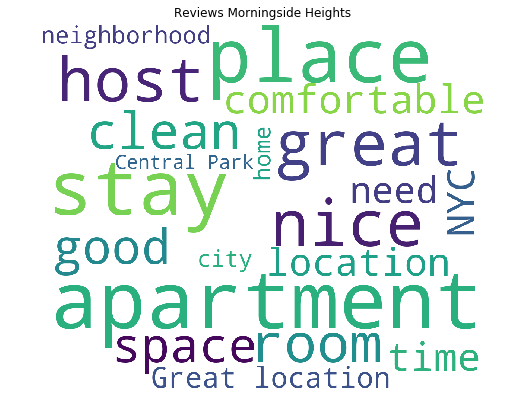

In [31]:
DELETE_WORDS = []
def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string

#Remove short words
MIN_LENGTH = 0
def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+word+' ',' ',1)
    return text_string


#Set up side by side clouds
COL_NUM = 1
ROW_NUM = 1
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(8,8))

#text_string = remove_words(all_rev,DELETE_WORDS=['apartment','host','place','stay'])
text_string = remove_words(all_rev)
text_string2 = remove_short_words(text_string)
ax = axes 
ax.set_title('Reviews Morningside Heights')
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=1200,height=1000,max_words=20).generate(text_string2)
ax.imshow(wordcloud)
ax.axis('off')
plt.show()

#### Complexity

In [32]:
def get_complexity(text):
    num_chars=len(text)
    num_words=len(word_tokenize(text))
    num_sentences=len(sent_tokenize(text))
    vocab = {x.lower() for x in word_tokenize(text)}
    return len(vocab),int(num_chars/num_words),int(num_words/num_sentences),len(vocab)/num_words

In [33]:
get_complexity(all_rev)

(5766, 4, 15, 0.06453851492019431)

#### Sentiment analysis with vader

In [34]:
def vader_comparison(texts):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    headers = ['pos','neg','neu','compound']
    print('  pos\t','neg\t','neu\t','compound')
    analyzer = SentimentIntensityAnalyzer()

    sentences = sent_tokenize(texts)
    pos=compound=neu=neg=0
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        pos+=vs['pos']/(len(sentences))
        compound+=vs['compound']/(len(sentences))
        neu+=vs['neu']/(len(sentences))
        neg+=vs['neg']/(len(sentences))
    print('%1.2f\t'%pos,'%1.2f\t'%neg,'%1.2f\t'%neu,'%1.2f\t'%compound)

In [35]:
vader_comparison(all_rev)

  pos	 neg	 neu	 compound
0.26	 0.02	 0.72	 0.40	


#### Summarization 

In [36]:
print(gensim.summarization.keywords(all_rev,words=10))

great
place
places
stayed
stay
staying
stays
hosts
host
hosting
hosted
located
location
locations
locates
locate
apartment
apartments
apartement
apart
clean
cleaning
cleaned
cleans
nice
nicely
good
amp


#### LDA

In [37]:
texts = [[word for word in all_rev.lower().split()
        if word not in STOPWORDS and word.isalnum()]]

In [38]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
#Set parameters
num_topics = 1
passes = 30
lda = LdaModel(corpus,
              id2word=dictionary,
              num_topics=num_topics,
              passes=passes)

In [39]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_words=8))

[   (   0,
        '0.022*"great" + 0.021*"place" + 0.015*"apartment" + 0.015*"stay" + '
        '0.010*"location" + 0.009*"nice" + 0.008*"host" + 0.008*"clean"')]
